# Disseration Experiment 2 
# Metrics to Measure SHAP Values
Ciaran Finnegan August 2023

In [1]:
# Import libs
import numpy as np
import pandas as pd
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
import shap
import random

from sklearn.preprocessing import LabelEncoder
import warnings
import sklearn.metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Classifier training (not used for explainability)
from sklearn.model_selection import train_test_split




## Import Data

In [2]:
df = pd.read_csv('credit_default_data.csv')
df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


### Basic Feature Engineering

In [3]:
# List of categorical columns
cat_cols = ['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']

# Adjust cat columns to range from 0
df[cat_cols] = df[cat_cols] = df[cat_cols].apply(LabelEncoder().fit_transform)

In [4]:
X = df.drop(columns=['default'])
y = df['default']

In [5]:
# Set categorical columns to type category
for c in cat_cols:
    X[c] = X[c].astype('category')

In [6]:
# Convert column names to a list
feature_names = X.columns.tolist()

### Split Data into Test/Training Datasets

In [7]:
# Split into inference and training splits
X_train, X_inf, y_train, y_inf = train_test_split(X, y, test_size=0.25, random_state=123)

# Split Train into train test
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.25, random_state=123)

In [8]:
X_train = X_train.reset_index(drop=True)
X_test= X_test.reset_index(drop=True)
X_inf = X_inf.reset_index(drop=True)

y_train = y_train.reset_index(drop=True)
y_test= y_test.reset_index(drop=True)
y_inf = y_inf.reset_index(drop=True)

### Basic Additional Data Exploration (Training Data)

In [9]:
# Train model Stats

print("Number of Features:", X_train.shape[1])
print("Number Continuous Features:", X_train.shape[1] - len(cat_cols))
print("Number Categorical Features:", len(cat_cols))
print("Number Train Examples:", X_train.shape[0])
print("Number Positive Train Examples:", (y_train == 1).sum())
print("Number Negative Train Examples:", (y_train == 0).sum())

Number of Features: 23
Number Continuous Features: 14
Number Categorical Features: 9
Number Train Examples: 16875
Number Positive Train Examples: 3741
Number Negative Train Examples: 13134


## Train Model

In [10]:
# 3. Train an LGBMClassifier
model = lgb.LGBMClassifier()
model.fit(X_train, y_train)


#model = RandomForestClassifier()
#model.fit(X_train, y_train)  

LGBMClassifier()

## Compute SHAP Values

### Full Dataset

In [11]:
# 4. Compute SHAP values
explainer = shap.Explainer(model)
shap_values = explainer.shap_values(X_test)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [12]:
# 5. Display in tabular format
df_X_test = pd.DataFrame(X_test, columns=feature_names)
df_shap = pd.DataFrame(shap_values[1], columns=[f"{name}_SHAP" for name in feature_names])  # Index 1 for positive class
predictions = model.predict(X_test)
df_X_test['Prediction'] = predictions

In [13]:
# Combining feature values, SHAP values, and predictions into one DataFrame
result = pd.concat([df_X_test, df_shap], axis=1)

In [14]:
# Display the table (for demonstration purposes, show only the first 5 instances)
print(result.head())

   LIMIT_BAL SEX EDUCATION MARRIAGE  AGE PAY_0 PAY_2 PAY_3 PAY_4 PAY_5  ...  \
0      50000   0         1        2   24     2     2     2     2     2  ...   
1     120000   1         3        2   26     1     1     1     1     1  ...   
2     340000   0         1        1   53     1     1     1     0     0  ...   
3      50000   0         1        2   28     2     2     2     2     2  ...   
4     150000   0         2        1   31     4     4     2     2     2  ...   

  BILL_AMT3_SHAP  BILL_AMT4_SHAP  BILL_AMT5_SHAP  BILL_AMT6_SHAP  \
0      -0.018087       -0.011665       -0.001804       -0.028289   
1      -0.024824        0.011808       -0.011015       -0.020239   
2      -0.070267        0.075647       -0.004757        0.010282   
3      -0.036549        0.005163        0.027942       -0.030055   
4       0.058568       -0.000523        0.005793        0.059847   

   PAY_AMT1_SHAP  PAY_AMT2_SHAP  PAY_AMT3_SHAP  PAY_AMT4_SHAP  PAY_AMT5_SHAP  \
0       0.027474      -0.036818     

### Take a single observation in the test set 

In [15]:
def single_observation_summary(sample,model,Y_test,explainer):
    rand = random.randrange(len(sample)) 
    single_record = sample.iloc[[rand]]
    label = Y_test.loc[single_record.index]
    score = model.predict_proba(single_record)[:,1]
    shap_values = explainer.shap_values(single_record)
    return single_record,label,score,shap_values

In [16]:
df_sample,sample_label,sample_score,shap_values = single_observation_summary(X_test,model,y_test,explainer)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [17]:
df_sample

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
361,60000,1,1,1,45,3,4,2,2,3,...,58322,59781,8177,7757,0,3000,3100,0,1000,500


In [18]:
sample_label, sample_score

(361    1
 Name: default, dtype: int64,
 array([0.33398539]))

In [19]:
shap_values

[array([[-0.15344636,  0.04574187,  0.01061396, -0.04101478, -0.03358803,
         -0.33544027, -0.3590018 ,  0.02719105,  0.01267169, -0.21803437,
          0.06689   ,  0.08666566, -0.01789888, -0.04202678,  0.04474509,
          0.01235714,  0.11167425, -0.08778311,  0.00503784,  0.03737457,
         -0.13134606,  0.04517347, -0.00805906]]),
 array([[ 0.15344636, -0.04574187, -0.01061396,  0.04101478,  0.03358803,
          0.33544027,  0.3590018 , -0.02719105, -0.01267169,  0.21803437,
         -0.06689   , -0.08666566,  0.01789888,  0.04202678, -0.04474509,
         -0.01235714, -0.11167425,  0.08778311, -0.00503784, -0.03737457,
          0.13134606, -0.04517347,  0.00805906]])]

### Generate shap values and base line value for n random observations

In [20]:
modelRF = RandomForestClassifier()
modelRF.fit(X_train, y_train)  
y_pred = modelRF.predict(X_test)
score = modelRF.predict_proba(X_test)
sklearn.metrics.roc_auc_score(y_test.values, score[:,1])

matrix = confusion_matrix(y_test, y_pred)

label = pd.DataFrame(y_test)
test_data = X_test.join(label)


In [21]:
def generate_shap_values(model,data,number_of_sample):

    explainer = shap.TreeExplainer(model)
    expected_value = explainer.expected_value[0]
    if isinstance(expected_value, list):
        expected_value = expected_value[1]
    print(f"Explainer expected value: {round(expected_value,2)}")


    features = data.sample(n=number_of_sample)


    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        shap_values = explainer.shap_values(features)[1]
        shap_interaction_values = explainer.shap_interaction_values(features)
    if isinstance(shap_interaction_values, list):
        shap_interaction_values = shap_interaction_values[1]
    return shap_values, expected_value,shap_interaction_values,features,explainer

Select 5 observations and generate shap values

In [22]:
shap_values,expected_value,shap_interaction_values,sample,explainer = generate_shap_values(modelRF,X_test,5)

Explainer expected value: 0.78


Generate decision plot and feature summary plot

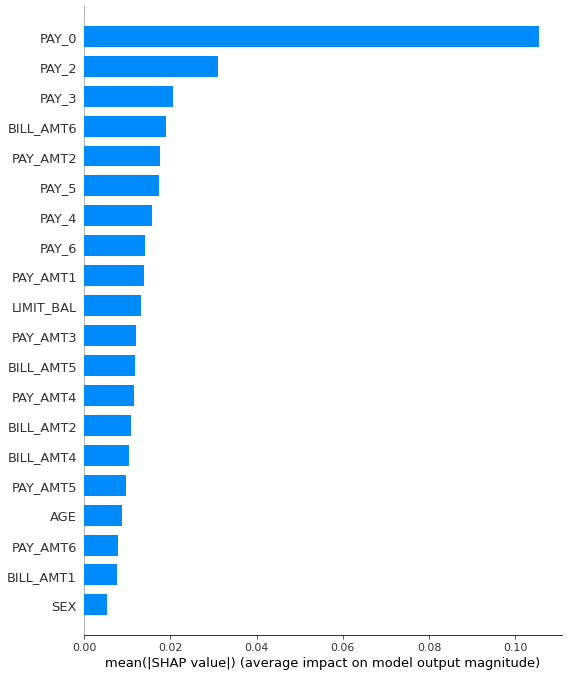

In [23]:
shap.summary_plot(shap_values,sample,plot_type='bar')